In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings(action='once')

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)

Populating the interactive namespace from numpy and matplotlib


This notebook will work with a dataset of daily ridership counts from Citibike. This dataset spans from May 2013 - March 2018. The models will be trained on data from 2013 until December 2016, while the January 2017 - March 2018 data will be reserved as a testing set.

After investigating this dataset, I found that it contained outliers consisting of days with no record. In order fill these gaps, I simply interpolate between the neighbouring days via averaging. 

In [3]:
base_path = '../data/ridership/'

partials = ['2013_q2-3.csv', '2013_q4.csv']
for y in range(2014, 2017):
    for n in range(1, 5):
        partials.append(f"{y}_q{n}.csv")

def read_and_clean(fname):
    trip_col = "Trips over the past 24-hours (midnight to 11:59pm)"
    df = pd.read_csv(f"{base_path}{fname}", index_col="Date", usecols=["Date", trip_col])
    
    # Replace 0 values with the average of their left and right neighbours, interpolate between
    df[df[trip_col] == 0] = np.nan
    df = df.where(~np.isnan(df[trip_col]), other=(df.fillna(method='ffill') + df.fillna(method='bfill'))/2)
    return df
        
train = pd.concat(list(map(lambda fname: read_and_clean(fname), partials)))

In [4]:
print(train.shape)
train.head()

(1315, 1)


,Trips over the past 24-hours (midnight to 11:59pm)
Date,
5/27/2013,9767.0
5/28/2013,5215.0
5/29/2013,10981.0
5/30/2013,9850.0
5/31/2013,9253.0


In [5]:
partials = []
for n in range(1, 5):
    partials.append(f"2017_q{n}.csv")
    
partials.append("2018_q1.csv")
test = pd.concat(list(map(lambda fname: read_and_clean(fname), partials)))

In [6]:
print(test.shape)
test.head()

(455, 1)


,Trips over the past 24-hours (midnight to 11:59pm)
Date,
1/1/17,16009.0
1/2/17,8921.0
1/3/17,14198.0
1/4/17,34039.0
1/5/17,28393.0


As the values in this dataset can be very large and highly variable. I will apply a feature scalar to project all values within a range of $[0, 1]$, then any predictions can be projected back to obtain it's real value. I was largely inspired by [this paper's](https://arxiv.org/pdf/1503.06462.pdf) suggestions.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_idx = train.index
train = train.values

test_idx = test.index
test = test.values

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In order to develop a forecasting model, I will have to construct the features as a time series. I will use a rolling window technique to extract contiguous dates, where the last date in each window will be the target.

In [8]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window_size = 5 # Given the last 4 days, predict the 5th

X_train = rolling_window(np.transpose(train), window_size)
X_train = X_train.reshape(X_train.shape[1], window_size)
X_train, Y_train = X_train[:, :-1], X_train[:, -1]

X_test = rolling_window(np.transpose(test), window_size)
X_test = X_test.reshape(X_test.shape[1], window_size)
X_test, Y_test = X_test[:, :-1], X_test[:, -1]

The following `class` is responsible for plotting the real time training and testing loss as the Neural Network is trained. 

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.metrics import categorical_accuracy

# Plot loss after each training epoch
class PlotLosses(keras.callbacks.Callback):
    def __init__(self, model, X_test, Y_test):
        self.model = model
        self.X_test = X_test.reshape(X_test.shape[0], window_size-1, 1)
        self.Y_test = Y_test
        super().__init__()
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.test_losses.append(self.model.evaluate(self.X_test, self.Y_test))
        self.i += 1

        clear_output(wait=True)
        
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="Training Loss")
        plt.xlabel("Epoch")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.test_losses, label="Test Losses", color='r')
        plt.xlabel("Epoch")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:871: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/usr/local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/backend.py:4422: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/Kris/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))

### Recurrent Neural Network Models

As I wanted my ideal model to be able to learn long term dependencies over time, I knew that a recurrent neural network architecture would be ideal. 

During my experimentation in building this network, I tried different recurrent layers and compared their performance. The two main recurrent architecture I experiemented with were the Long short-term Memory (LSTM) unit and the Gated Recurrent Unit (GRU). As noted by [this paper](https://arxiv.org/pdf/1412.3555.pdf), GRUs seemed especially promising due to it's ability to learn given fewer training samples, as well as it's reduced computational resource requirements.

I largely found that the GRU based model had better performance on the test dataset than the LSTM based model.

#### Gated Recurrent Unit (GRU) Model

In [10]:
model = Sequential([
    GRU(128, input_shape=(window_size - 1, 1), return_sequences=True),
    Dropout(0.3),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='rmsprop')

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


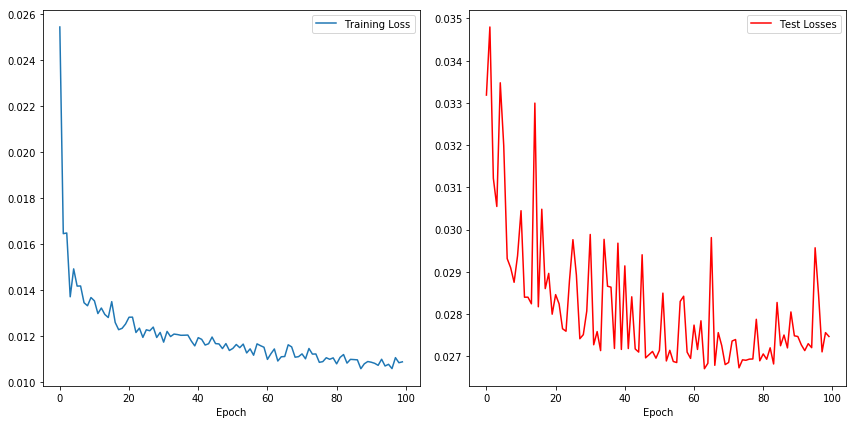

In [11]:
plot_losses = PlotLosses(model, X_test, Y_test)

# Format X_* as (number of samples, number of timesteps, number of features per timestep)
model.fit(X_train.reshape(X_train.shape[0], window_size-1, 1), Y_train, epochs=100, callbacks=[plot_losses])

In [12]:
model.evaluate(X_test.reshape(X_test.shape[0], window_size-1, 1), Y_test)

451/451 [==============================] - 0s 150us/step


0.027469760947396147

In [41]:
def visualize(model, x, y, title, x_shape=None, x_labels=None, x_labels_freq=15):
    predictions = []
    targets = []
    
    # Project back to real values
    for idx, xt in enumerate(x):
        if x_shape:
            xt = xt.reshape(x_shape)
        t = scaler.inverse_transform([y[idx]])[0]
        p = scaler.inverse_transform(model.predict(xt))[0]

        targets.append(t)
        predictions.append(p)

    # Plot forecast + targets
    plt.title(title)
    plt.xlabel("Date (D-M-Y)")
    plt.ylabel("Rides per Day")
    
    plt.plot(targets, label="Targets")
    plt.plot(predictions, label="Forecasted")
    
    if x_labels:
        plt.xticks(range(0, len(targets), x_labels_freq), x_labels[window_size-1::x_labels_freq], rotation=90)
    
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


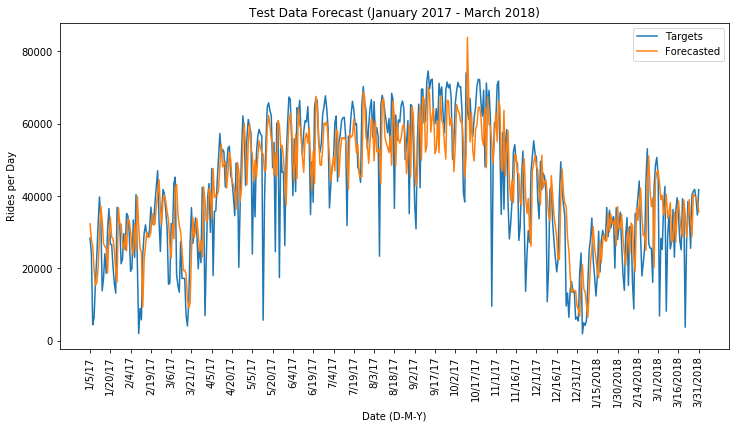

In [57]:
visualize(model, X_test, Y_test, "Test Data Forecast (January 2017 - March 2018)", x_shape=(1, window_size-1, 1), x_labels=list(test_idx))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


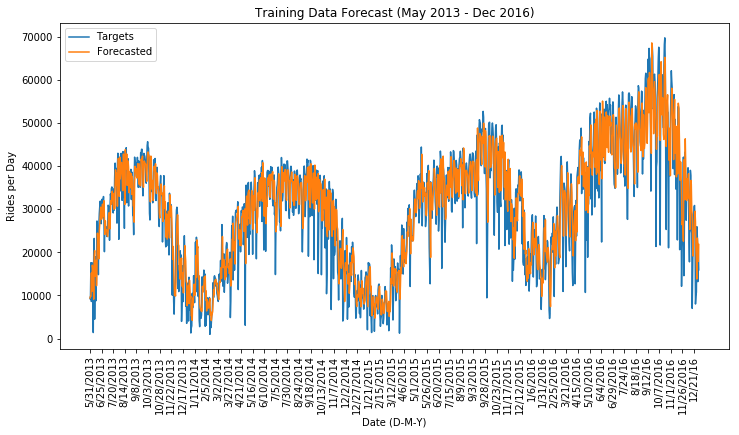

In [44]:
visualize(model, X_train, Y_train, "Training Data Forecast (May 2013 - Dec 2016)", x_shape=(1, window_size-1, 1), x_labels=list(train_idx), x_labels_freq=25)

#### Long Short Term Memory (LSTM) Network Model

In [45]:
lstm_model = Sequential([
    LSTM(128, input_shape=(window_size - 1, 1), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


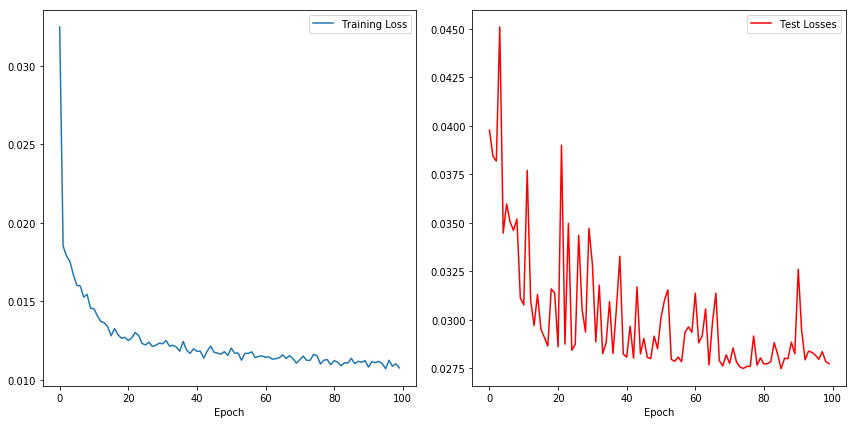

In [46]:
plot_losses = PlotLosses(lstm_model, X_test, Y_test)

# Format X_* as (number of samples, number of timesteps, number of features per timestep)
lstm_model.fit(X_train.reshape(X_train.shape[0], window_size-1, 1), Y_train, epochs=100, callbacks=[plot_losses])

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


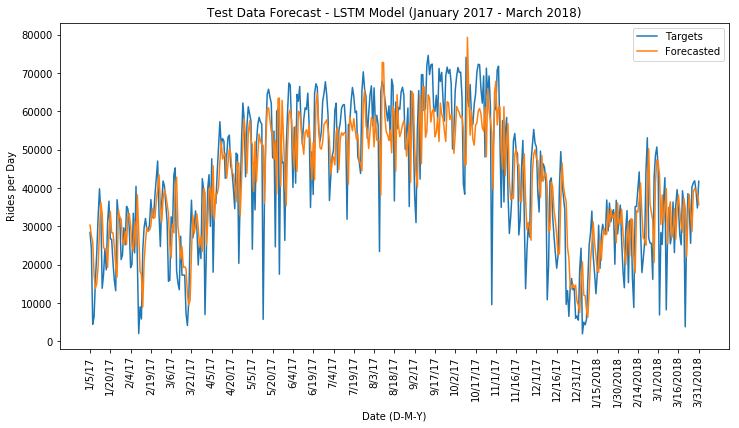

In [48]:
visualize(lstm_model, X_test, Y_test, "Test Data Forecast - LSTM Model (January 2017 - March 2018)", x_shape=(1, window_size-1, 1), x_labels=list(test_idx))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


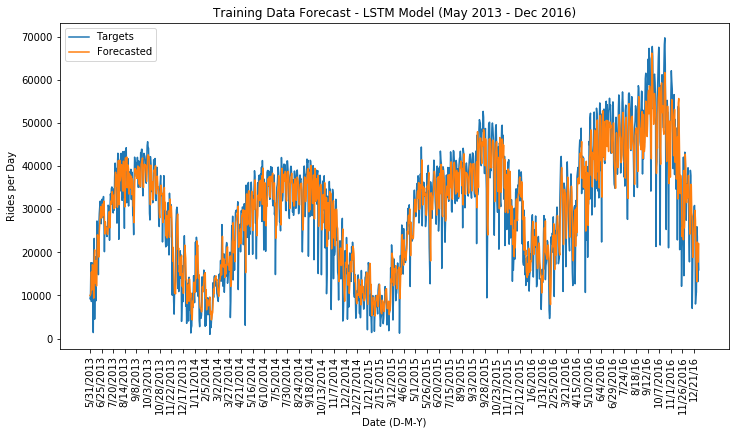

In [49]:
visualize(lstm_model, X_train, Y_train, "Training Data Forecast - LSTM Model (May 2013 - Dec 2016)", x_shape=(1, window_size-1, 1), x_labels=list(train_idx), x_labels_freq=25)

After experiementing with Neural Networks based models, I wanted to see how similar models, namely linear and SVM based models would perform.

#### Linear Model

I largely found that a linear model was too simple to capture the complexities in representing the dataset. I was impressed at it's ability to track the general trend over time.

In [51]:
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor()
sgd_model.fit(X_train, Y_train)

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


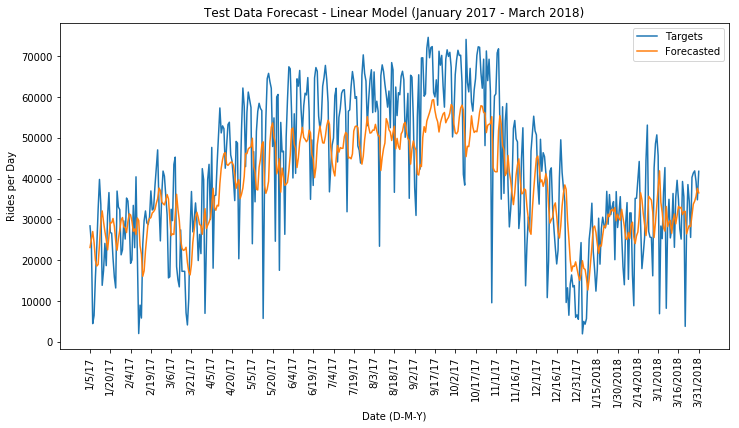

In [52]:
visualize(sgd_model, X_test, Y_test, "Test Data Forecast - Linear Model (January 2017 - March 2018)", x_labels=list(test_idx))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


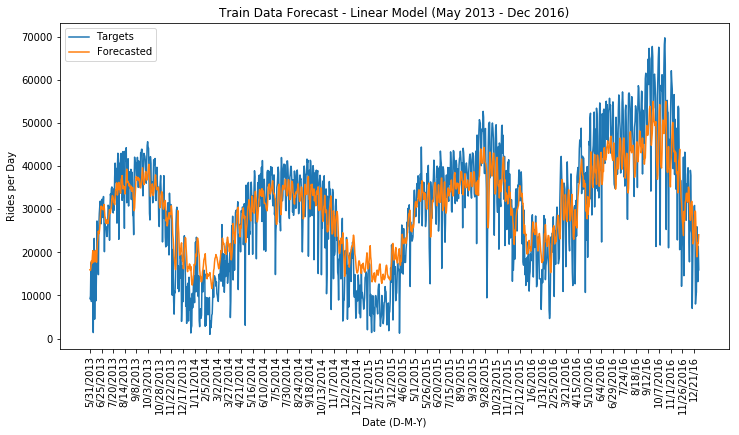

In [53]:
visualize(sgd_model, X_train, Y_train, "Train Data Forecast - Linear Model (May 2013 - Dec 2016)", x_labels=list(train_idx), x_labels_freq=25)

#### Support Vector Regressor (SVR) Model

The next model is based off of a Support Vector Machine (SVM), specialized for regression tasks. I'm very impressed with it's ability to captured more of the nuances in the data.

In [54]:
from sklearn.svm import SVR

svr_rbf_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf_model.fit(X_train, Y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


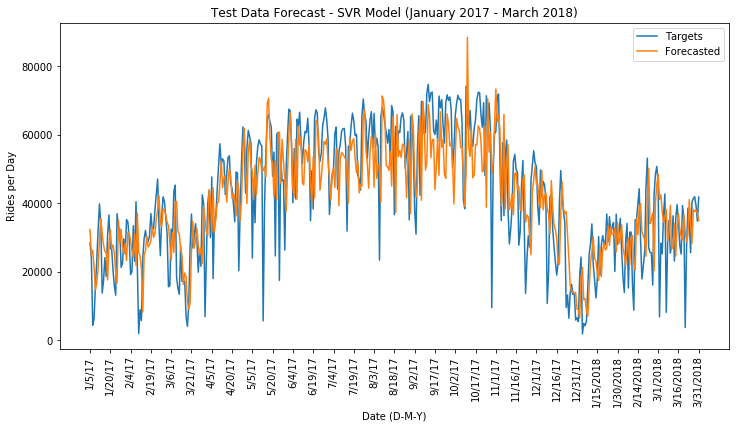

In [55]:
visualize(svr_rbf_model, X_test, Y_test, "Test Data Forecast - SVR Model (January 2017 - March 2018)", x_labels=list(test_idx))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


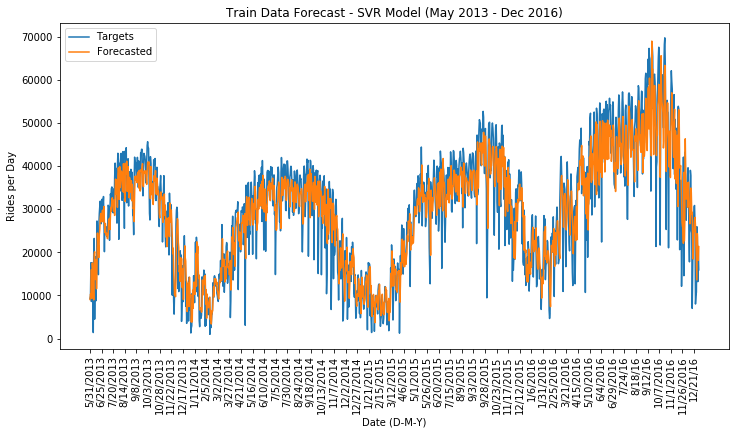

In [56]:
visualize(svr_rbf_model, X_train, Y_train, "Train Data Forecast - SVR Model (May 2013 - Dec 2016)", x_labels=list(train_idx), x_labels_freq=25)